In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [25]:
from data.utils import make_uniform, make_joint, make_joint3

In [3]:
df = pd.read_csv(Path.cwd() / 'data' / '2239075.csv', usecols= ['DATE', 'SNOW'], parse_dates=['DATE'])
df['YEAR'] = df['DATE'].dt.year
df.head()

,DATE,SNOW,YEAR
0,1967-05-11,0.0,1967
1,1967-05-12,0.0,1967
2,1967-05-13,0.0,1967
3,1967-05-14,0.0,1967
4,1967-05-15,0.0,1967


In [5]:
snow = df.groupby('YEAR')['SNOW'].sum()
snow.head()

YEAR
1967    28.6
1968    44.7
1969    99.2
1970    66.8
1971    54.6
Name: SNOW, dtype: float64

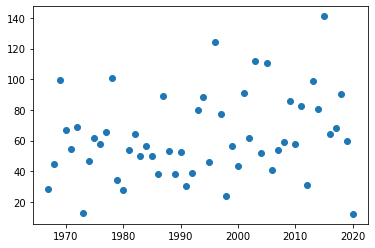

In [9]:
plt.scatter(x=snow.index, y=snow.values)

In [15]:
pmf_snowfall = Pmf.from_seq(snow)
mean, std = pmf_snowfall.mean(), pmf_snowfall.std()

In [16]:
dist = ss.norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

<AxesSubplot:>

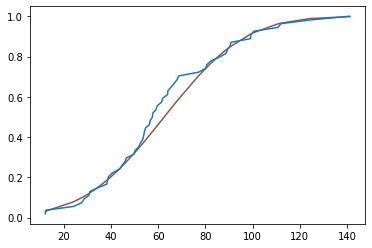

In [17]:
plt.plot(qs, ps, color='C5', label='model')
pmf_snowfall.make_cdf().plot(label='data')

In [18]:
data = snow.reset_index()
offset = round(data['YEAR'].mean(), 0)
data['x'] = data['YEAR'] - offset
data['y'] = data['SNOW']

In [21]:
formula = 'y ~ x'
results = smfa.ols(formula, data=data).fit()
results.params, results.resid.std()

(Intercept    62.780489
 x             0.423941
 dtype: float64,
 26.56611464774299)

In [23]:
qs1 = np.linspace(-0.5, 1.4, 51)
prior_slope = make_uniform(qs1, name='Slope')
qs2 = np.linspace(53, 71, 41)
prior_inter = make_uniform(qs2, name='Intercept')
qs3 = np.linspace(20, 33, 31)
prior_sigma = make_uniform(qs3, name='Sigma')

In [26]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior

-0.5  53.0  20.000000    0.000015
            20.433333    0.000015
            20.866667    0.000015
            21.300000    0.000015
            21.733333    0.000015
                           ...   
 1.4  71.0  31.266667    0.000015
            31.700000    0.000015
            32.133333    0.000015
            32.566667    0.000015
            33.000000    0.000015
Name: , Length: 64821, dtype: float64

In [27]:
# 모수들을 알고 있다고 가정 → 흐름을 파악하기 위한 임시 작업
inter = 63
slope = 0.42
sigma = 27

In [29]:
xs = data['x']
ys = data['y']
expected = inter + slope * xs
resid = ys - expected
densities = ss.norm(0, sigma).pdf(resid)
likelihood = densities.prod()
likelihood

1.0298257696756573e-110

In [30]:
likelihood = prior.copy()
for slope, inter, sigma in prior.index:
    expected = inter + slope * xs
    resid = ys - expected
    densities = ss.norm(0, sigma).pdf(resid)
    likelihood[slope, inter, sigma] = densities.prod()

In [31]:
posterior = prior * likelihood
posterior.normalize()

7.492187955221334e-112

In [32]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

(62.704810980102664, array([56.6, 68.3]))

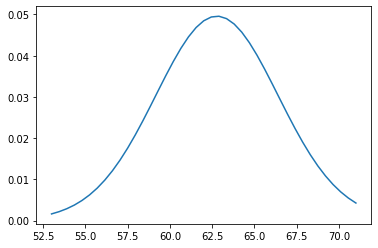

In [33]:
posterior_inter.plot()
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(0.4238255410248934, array([0.032, 0.83 ]), array(-0.082), array(0.04242066))

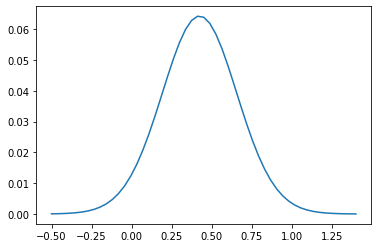

In [38]:
posterior_slope.plot()
posterior_slope.mean(), posterior_slope.credible_interval(0.9), posterior_slope.quantile(0.02), posterior_slope.make_cdf()(0)

In [39]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
table = pd.read_html(url)[0]

In [41]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['time'] = pd.to_timedelta(table['Time'])
# 42.195 / 1.61
table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh, Scotland",ARRS[9],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch, New Zealand",ARRS[9],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[9],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[9],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[9]",NaN,1981-12-06,0 days 02:08:18,12.252533


In [47]:
offset = pd.to_datetime('1995')
timedelta = data['date'] - offset
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y,x
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh, Scotland",ARRS[9],NaN,1970-07-23,0 days 02:09:28.800000,12.140871,-24.444201
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch, New Zealand",ARRS[9],NaN,1974-01-31,0 days 02:09:12,12.167183,-20.917753
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[9],NaN,1978-02-05,0 days 02:09:05.600000,12.177236,-16.903954
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[9],NaN,1980-04-26,0 days 02:09:01,12.184472,-14.683496
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[52] ARRS[9]",NaN,1981-12-06,0 days 02:08:18,12.252533,-13.070858


In [48]:
formula = 'y ~ x'
results = smfa.ols(formula, data=data).fit()
results.params, results.resid.std()

(Intercept    12.464040
 x             0.015931
 dtype: float64,
 0.04419653543387639)

In [51]:
qs1 = np.linspace(0.012, 0.018, 51)
prior_slope = make_uniform(qs1, name='Slope')
qs2 = np.linspace(12.0, 13.2, 41)
prior_inter = make_uniform(qs2, name='Intercept')
qs3 = np.linspace(0.01, 0.11, 31)
prior_sigma = make_uniform(qs3, name='Sigma')

In [52]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior

0.012  12.0  0.010000    0.000015
             0.013333    0.000015
             0.016667    0.000015
             0.020000    0.000015
             0.023333    0.000015
                           ...   
0.018  13.2  0.096667    0.000015
             0.100000    0.000015
             0.103333    0.000015
             0.106667    0.000015
             0.110000    0.000015
Name: , Length: 64821, dtype: float64

In [53]:
xs = data['x']
ys = data['y']
likelihood = prior.copy()
for slope, inter, sigma in prior.index:
    expected = inter + slope * xs
    resid = ys - expected
    densities = ss.norm(0, sigma).pdf(resid)
    likelihood[slope, inter, sigma] = densities.prod()

In [54]:
posterior = prior * likelihood
posterior.normalize()

162804138580.70926

In [55]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

(12.463254254673476, array([12.45, 12.48]))

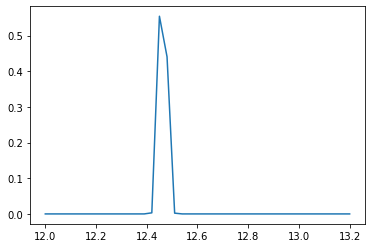

In [56]:
posterior_inter.plot()
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(0.01592827940506412, array([0.01476, 0.01716]), array(0.01596))

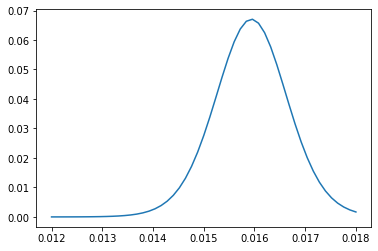

In [57]:
posterior_slope.plot()
posterior_slope.mean(), posterior_slope.credible_interval(0.9), posterior_slope.quantile(0.5)

In [74]:
sample = posterior.choice(1001)
xs = np.arange(-25, 50)
pred = np.zeros((len(sample), len(xs)))
for i, (slope, inter, sigma) in enumerate(sample):
    epsilon = ss.norm(0, sigma).rvs(len(xs))
    pred[i] = inter + slope * xs + epsilon

In [75]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
low

array([11.97190314, 11.9863579 , 12.00800802, 12.02407912, 12.03551465,
       12.05267823, 12.0682278 , 12.07593639, 12.10306564, 12.12276103,
       12.13536361, 12.15240609, 12.1646635 , 12.1847833 , 12.19623957,
       12.2198725 , 12.2359776 , 12.24727146, 12.26382639, 12.27870273,
       12.29662266, 12.31301572, 12.32707354, 12.34302821, 12.36219572,
       12.38007157, 12.39223085, 12.40880799, 12.42519144, 12.44414152,
       12.45471305, 12.47161611, 12.48848585, 12.50497773, 12.51999822,
       12.5293181 , 12.55208319, 12.56567799, 12.58725743, 12.60297631,
       12.61337473, 12.63112691, 12.64411982, 12.66391168, 12.67797999,
       12.6908255 , 12.71157617, 12.72304547, 12.73895483, 12.7535504 ,
       12.77174581, 12.7922621 , 12.80354844, 12.82290298, 12.83537261,
       12.85620144, 12.86680424, 12.88710224, 12.89775482, 12.92038226,
       12.92471507, 12.94137288, 12.95974538, 12.97855404, 12.99093834,
       13.00459319, 13.01997752, 13.02947008, 13.05202819, 13.07

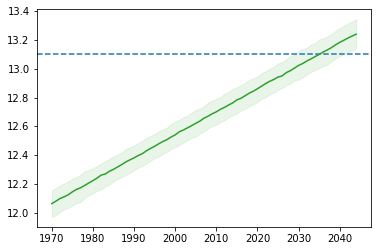

In [76]:
times = pd.to_timedelta(xs * 365.24, unit='days') + offset
plt.axhline(13.1, linestyle='--')
plt.fill_between(times, low, high, color='C2', alpha=0.1)
plt.plot(times, median, color='C2')

In [77]:
interp1d(high, xs)(13.1)

array(34.06790948)

In [78]:
future = np.array([interp1d(high, xs)(13.1), interp1d(median, xs)(13.1), interp1d(low, xs)(13.1)])
future_times = pd.to_timedelta(future * 365.24, unit='days') + offset
future_times

DatetimeIndex(['2029-01-24 23:07:05.585548800',
               '2035-01-14 10:43:34.231180800',
               '2040-12-15 13:32:40.078550400'],
              dtype='datetime64[ns]', freq=None)